# 库引入模块

In [1]:
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple, Any
import random
from copy import deepcopy
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = np.load("stocks_500.npy", allow_pickle=True).item()
print(len(data))
print(type(data))
print(data)




499
<class 'dict'>
{'603596.csv':              open   high    low  close      volume       amount  \
2020-01-02  15.79  16.32  15.72  16.28   5115023.0  118356118.0   
2020-01-03  16.15  16.26  15.80  16.07   4761454.0  109648288.0   
2020-01-06  15.94  16.60  15.75  16.21   5252090.0  122594336.0   
2020-01-07  16.14  16.80  16.10  16.64   4340288.0  103151280.0   
2020-01-08  16.35  17.24  16.34  16.88   5474994.0  132646382.0   
...           ...    ...    ...    ...         ...          ...   
2025-10-13  48.00  49.16  47.75  48.56  13221200.0  641280142.0   
2025-10-14  48.99  49.22  46.48  46.76  17213357.0  818310031.0   
2025-10-15  46.76  48.97  46.45  48.73  12851105.0  612552744.0   
2025-10-16  48.00  50.75  48.00  48.82  15364010.0  761902720.0   
2025-10-17  48.50  48.82  46.50  46.83  15320021.0  720092935.0   

            outstanding_share  turnover  
2020-01-02        171793500.0  0.029774  
2020-01-03        171793500.0  0.027716  
2020-01-06        171793500.0  0.03

# 数据准备模块

In [3]:
class DataLoader:
    """股票数据加载器"""
    def __init__(self, start_date='2020-01-02', end_date='2025-10-17'):
        self.start_date = start_date
        self.end_date = end_date
        self.data = pd.DataFrame()

    
    def load_real_data(self):
        raw = np.load("stocks_500.npy", allow_pickle=True).item() # 取出 dict    
        data = {}
        for key, df in raw.items():
            stock = key.replace('.csv', '')
            data[stock] = df
    
        frames = []
        i=0
        for stock, df in data.items():
            i+=1
            # 把 index（日期）变成一列
            df = df.reset_index().rename(columns={'index': 'date'})
            # 将日期转换为 datetime，与 sample 完全一致
            df['date'] = pd.to_datetime(df['date'])
            # 加入股票列
            df['stock'] = stock

            frames.append(df)
            if i==30:
                break

        # 合并所有股票
        full_df = pd.concat(frames, ignore_index=True)

        # 设置 MultiIndex
        full_df = full_df.set_index(['date', 'stock'])
        # 排序以保证和 sample 完全一致
        full_df = full_df.sort_index()

        self.data = full_df
        return full_df

    def get_train_test_split(self, test_size=0.3):
        """按时间划分训练集和测试集并加入标签"""
        dates = self.data.index.get_level_values('date').unique().sort_values()

        split_idx = int(len(dates) * (1 - test_size))
        
        train_dates = dates[:split_idx]
        test_dates = dates[split_idx:]

        train_data = self.data.loc[self.data.index.get_level_values('date').isin(train_dates)].copy()
        test_data  = self.data.loc[self.data.index.get_level_values('date').isin(test_dates)].copy()

        # 计算未来收益标签 
        train_data["returns_5d"] = train_data.groupby(level="stock")["close"].pct_change(5).shift(-5)
        train_data["returns_10d"] = train_data.groupby(level="stock")["close"].pct_change(10).shift(-10)

        # 删除没有标签的数据
        train_data = train_data.dropna()

        # 计算未来收益标签 
        test_data["returns_5d"] = test_data.groupby(level="stock")["close"].pct_change(5).shift(-5)
        test_data["returns_10d"] = test_data.groupby(level="stock")["close"].pct_change(10).shift(-10)

        # 删除没有标签的数据
        test_data = test_data.dropna()
        
        return train_data, test_data

# 遗传规划核心模块

In [4]:
class Node:
    """遗传规划树节点"""
    def __init__(self, value=None, node_type='terminal', children=None):
        self.value = value  # 节点值（如运算符或变量名）
        self.node_type = node_type  # 'terminal'或'function'
        self.children = children if children else []
    
    def depth(self):
        """计算树深度"""
        if not self.children:
            return 1
        else:
            return 1 + max(child.depth() for child in self.children)
    
    def __str__(self):
        if self.node_type == 'terminal':
            return str(self.value)
        else:
            children_str = ', '.join(str(child) for child in self.children)
            return f"{self.value}({children_str})"

In [5]:
class GeneticProgramming:

    """遗传规划主类"""
    def __init__(self, 
                 population_size=100,
                 max_generations=50,
                 max_depth=5,
                 crossover_rate=0.8,
                 mutation_rate=0.2,
                 tournament_size=5):
        
        self.population_size = population_size
        self.max_generations = max_generations
        self.max_depth = max_depth
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
        
        # 定义函数集和终止符集
        self.functions = {
            '+': lambda x, y: x + y,
            '-': lambda x, y: x - y,
            '*': lambda x, y: x * y,
            '/': lambda x, y: x / (np.where(y >= 0, 1.0, -1.0) * np.maximum(np.abs(y), 1e-3)),
            'log': lambda x: np.log(abs(x) + 1e-10),
            'sqrt': lambda x: np.sqrt(abs(x)),
            'abs': lambda x: np.abs(x),
            'ts_mean': lambda x, window: x.rolling(window=window).mean(),
            'ts_std': lambda x, window: x.rolling(window=window).std(),
            'ts_delay': lambda x, lag: x.shift(lag),
        }
        
        self.function_arities = {
            '+': 2, '-': 2, '*': 2, '/': 2,
            'log': 1, 'sqrt': 1, 'abs': 1,
            'ts_mean': 2, 'ts_std': 2, 'ts_delay': 2
        }
        
        self.terminals = ['close', 'volume', 'amount', 'low', 'high', 'open', 'outstanding_share', 'turnover']
        self.constants = [-1, 0.5, 1, 2, 5, 10]

    """创建随机树"""        
    def create_random_tree(self, max_depth=None, method='grow'):

        if max_depth is None:
            max_depth = self.max_depth
        
        if max_depth == 1 or (method == 'grow' and random.random() < 0.5):
            # 创建终止节点
            if random.random() < 0.7:
                value = random.choice(self.terminals)
            else:
                value = random.choice(self.constants)
            return Node(value=value, node_type='terminal')
        else:
            # 创建函数节点
            func = random.choice(list(self.function_arities.keys()))
            arity = self.function_arities[func]
            
            children = []
            for _ in range(arity):
                child = self.create_random_tree(max_depth - 1, method)
                children.append(child)
            
            return Node(value=func, node_type='function', children=children)

    """初始化种群"""    
    def initialize_population(self):

        population = []
        for _ in range(self.population_size):
            # 一半用grow方法，一半用full方法
            method = 'grow' if random.random() < 0.5 else 'full'
            tree = self.create_random_tree(method=method)
            population.append(tree)
        return population
    
    """安全地将输入转换为整数，带有默认值和范围限制"""
    def _safe_int(self, v, default=10, lo=2, hi=60):
        try:
            # v 可能是 scalar / ndarray / Series
            if isinstance(v, np.ndarray):
                v = v[0]
            elif hasattr(v, "iloc"):  # pd.Series
                v = v.iloc[0]

            v = float(v)
            if not np.isfinite(v):
                return default
            
            v = int(round(v))
            if v < lo: v = lo
            if v > hi: v = hi
            return v
        except Exception:
            return default

    """评估树在特定股票上的值"""
    def evaluate_tree(self, tree, stock_data, stock_id):

        try:
            if tree.node_type == 'terminal':
                if isinstance(tree.value, (int, float, np.number)):
                    return pd.Series(float(tree.value), index=stock_data.index)

                elif isinstance(tree.value, str) and tree.value in stock_data.columns:
                    return stock_data[tree.value]

                else:
                    return pd.Series(np.nan, index=stock_data.index)
                
            else:
                # 函数节点
                func = self.functions[tree.value]
                child_values = [self.evaluate_tree(child, stock_data, stock_id) 
                                for child in tree.children]
                
                if tree.value in ['ts_mean', 'ts_std']:
                    series = child_values[0]              # 现在应当是 pd.Series（炸点1已修）
                    window = self._safe_int(child_values[1], default=10, lo=2, hi=60)
                    return func(series, window)

                elif tree.value == 'ts_delay':
                    series = child_values[0]
                    lag = self._safe_int(child_values[1], default=1, lo=1, hi=30)
                    return func(series, lag)
                
                elif len(child_values) == 1:
                    return func(child_values[0])
                
                else:
                    return func(child_values[0], child_values[1])
                
        except Exception as e:
            # 计算出错返回NaN
            return pd.Series(np.nan, index=stock_data.index)
    
    """计算 Rank IC（Spearman）"""
    def calculate_ic(self, factor_values, forward_returns, min_samples=10):
        factor_values = np.asarray(factor_values, dtype=float)
        forward_returns = np.asarray(forward_returns, dtype=float)

        valid_mask = np.isfinite(factor_values) & np.isfinite(forward_returns)
        if valid_mask.sum() < min_samples:
            return np.nan  # ✅ 不可计算，用 NaN 表示

        factor_valid = factor_values[valid_mask]
        returns_valid = forward_returns[valid_mask]

        factor_rank = pd.Series(factor_valid).rank(method='average')
        returns_rank = pd.Series(returns_valid).rank(method='average')

        ic = factor_rank.corr(returns_rank)
        return ic  # 可能仍是 NaN，让上层处理
    



    """评估个体适应度"""
    def evaluate_fitness(self, tree, data):
        try:
            all_ics = []
            coverages = []  # ✅ 新增：记录每个日期的有效覆盖率

            lookback_max = 60  # ts window 上限

            dates = sorted(data.index.get_level_values('date').unique())
            eval_dates = dates[lookback_max: max(lookback_max, len(dates))]

            if len(eval_dates) == 0:
                return -1e6

            sample_dates = random.sample(eval_dates, min(50, len(eval_dates)))





            for date in sample_dates:
                date_data = data.xs(date, level='date')

                date_factors = []
                date_returns = []

                # 该日横截面股票数（用于 coverage）
                total_stocks = len(date_data.index)
                if total_stocks == 0:
                    continue





                for stock_id in date_data.index:
                    stock_data = data.xs(stock_id, level='stock').loc[:date]
                    if len(stock_data) < 20:
                        continue

                    factor_series = self.evaluate_tree(tree, stock_data, stock_id)
                    factor_value = float(factor_series.iloc[-1])

                    forward_return = stock_data['returns_5d'].iloc[-1] if len(stock_data) > 0 else np.nan

                    if np.isfinite(factor_value) and np.isfinite(forward_return):
                        date_factors.append(factor_value)
                        date_returns.append(forward_return)

                # ✅ 新增：记录当日 coverage（在 ic 判断前记录，避免只挑“容易算出ic”的日子）
                coverage = len(date_factors) / total_stocks
                coverages.append(coverage)

                if len(date_factors) > 10:
                    ic = self.calculate_ic(np.array(date_factors), np.array(date_returns))
                    if np.isfinite(ic):
                        all_ics.append(float(ic))

            # === 汇总：IC 质量 ===
            min_days = 10
            all_ics = [ic for ic in all_ics if np.isfinite(ic)]
            if len(all_ics) < min_days:
                return -1e6

            ic_mean = float(np.mean(all_ics))
            ic_std = float(np.std(all_ics, ddof=1)) if len(all_ics) > 1 else 0.0
            if (not np.isfinite(ic_mean)) or (not np.isfinite(ic_std)) or ic_std < 1e-6:
                return -1e6
            ic_ir = ic_mean / ic_std

            # === 新增：coverage penalty ===
            # 平均覆盖率（越高越好）
            avg_cov = float(np.mean(coverages)) if len(coverages) > 0 else 0.0

            # 目标覆盖率：低于目标就惩罚
            cov_target = 0.60      # 可调：0.3~0.8 常见
            cov_weight = 0.50      # 可调：惩罚强度
            cov_penalty = cov_weight * max(0.0, cov_target - avg_cov)

            # === 复杂度惩罚 ===
            complexity_penalty = tree.depth() / self.max_depth * 0.1

            # fitness（你原来用 ic_ir，这里保持一致）
            fitness = ic_ir - complexity_penalty - cov_penalty

            return float(fitness) if np.isfinite(fitness) else -1e6

        except Exception:
            return -1e6

    
        
    """锦标赛选择（softmax），temperature 越大越随机"""
    def tournament_selection(self, population, fitness_scores, temperature=0.5):
        idxs = random.sample(range(len(population)), self.tournament_size)
        scores = np.array([fitness_scores[i] for i in idxs], dtype=float)

        # 数值稳定
        scores = np.nan_to_num(scores, nan=-1e9, neginf=-1e9, posinf=1e9)
        scores = scores - scores.max()

        probs = np.exp(scores / max(temperature, 1e-8))
        probs = probs / probs.sum()

        chosen = np.random.choice(idxs, p=probs)
        return population[chosen]


    """获取树的所有节点"""
    def get_all_nodes(self, tree):
        nodes = [tree]
        for child in tree.children:
            nodes.extend(self.get_all_nodes(child))
        return nodes
    
    """查找子节点在父节点中的索引"""    
    def find_child_index(self, tree, target_node):
        def _find_recursive(node, target):
            if node is target:
                return []
            
            for i, child in enumerate(node.children):
                result = _find_recursive(child, target)
                if result is not None:
                    return [i] + result
            
            return None
        
        path = _find_recursive(tree, target_node)
        return path
    

    """交叉操作"""
    def crossover(self, parent1, parent2):
        if random.random() > self.crossover_rate:
            return deepcopy(parent1), deepcopy(parent2)
        
        # 深度复制
        child1 = deepcopy(parent1)
        child2 = deepcopy(parent2)
        
        # 选择交叉点
        nodes1 = self.get_all_nodes(child1)
        nodes2 = self.get_all_nodes(child2)
        
        if len(nodes1) > 1 and len(nodes2) > 1:
            swap_node1 = random.choice(nodes1[1:])  # 跳过根节点
            swap_node2 = random.choice(nodes2[1:])
            
            # 找到子树
            parent1_child_idx = self.find_child_index(child1, swap_node1)
            parent2_child_idx = self.find_child_index(child2, swap_node2)
             # 交换子树           
            if parent1_child_idx is not None and parent2_child_idx is not None:
                swap_node1.children, swap_node2.children = swap_node2.children, swap_node1.children
        
        return child1, child2
    
    """变异操作"""
    def mutate(self, tree):

        if random.random() > self.mutation_rate:
            return deepcopy(tree)
        
        mutated = deepcopy(tree)
        nodes = self.get_all_nodes(mutated)
        
        if nodes:
            mutate_node = random.choice(nodes)
            
            if mutate_node.node_type == 'terminal':
                # 变异终止符
                if random.random() < 0.5:
                    mutate_node.value = random.choice(self.terminals)
                else:
                    mutate_node.value = random.choice(self.constants)
            else:
                # 变异函数
                new_func = random.choice(list(self.function_arities.keys()))
                mutate_node.value = new_func
                
                # 调整子节点数量
                new_arity = self.function_arities[new_func]
                current_arity = len(mutate_node.children)
                
                if new_arity > current_arity:
                    # 添加子节点
                    for _ in range(new_arity - current_arity):
                        new_child = self.create_random_tree(max_depth=2, method='grow')
                        mutate_node.children.append(new_child)
                elif new_arity < current_arity:
                    # 删除子节点
                    mutate_node.children = mutate_node.children[:new_arity]
        
        return mutated
    
    
    """主进化循环"""
    def evolve(self, data, verbose=True):
        # 初始化种群
        population = self.initialize_population()
        best_fitness_history = []
        avg_fitness_history = []
        
        for generation in range(self.max_generations):
            # 评估适应度
            fitness_scores = []
            for tree in population:
                fitness = self.evaluate_fitness(tree, data)
                fitness_scores.append(fitness)
            
            
            # 统计信息
            best_fitness = max(fitness_scores)
            avg_fitness = np.mean(fitness_scores)
            best_fitness_history.append(best_fitness)
            avg_fitness_history.append(avg_fitness)
            
            if verbose and generation % 5 == 0:
                print(f"Generation {generation}: Best Fitness = {best_fitness:.4f}, Avg Fitness = {avg_fitness:.4f}")
            
            # 选择优秀个体
            elite_size = max(2, int(self.population_size * 0.1))
            elite_indices = np.argsort(fitness_scores)[-elite_size:]
            elite_population = [population[i] for i in elite_indices]
            
            # 创建新一代
            new_population = elite_population.copy()
            
            while len(new_population) < self.population_size:
                # 选择父代
                parent1 = self.tournament_selection(population, fitness_scores)
                parent2 = self.tournament_selection(population, fitness_scores)
                
                # 交叉
                child1, child2 = self.crossover(parent1, parent2)
                
                # 变异
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                
                new_population.extend([child1, child2])
            
            population = new_population[:self.population_size]
        
        # 选择最终的最佳个体
        final_fitness = [self.evaluate_fitness(tree, data) for tree in population]
        best_idx = np.argmax(final_fitness)
        best_individual = population[best_idx]
        
        return best_individual, best_fitness_history, avg_fitness_history

# 多因子合成模块 

In [6]:
class MultiFactorModel:
    """多因子合成模型"""
    def __init__(self):
        self.factors = []
        self.factor_weights = []
        
    def add_factor(self, factor_tree, gp_engine, weight=None):
        """添加因子"""
        self.factors.append((factor_tree, gp_engine))
        self.factor_weights.append(weight)
        
    def calculate_factors(self, data, date):
        """计算所有因子在特定日期的值"""
        factor_matrix = []
        
        date_data = data.xs(date, level='date')
        stock_ids = date_data.index.tolist()
        
        for stock_id in stock_ids:
            stock_data = data.xs(stock_id, level='stock').loc[:date]
            stock_factors = []
            
            for factor_tree, gp_engine in self.factors:
                raw_value = gp_engine.evaluate_tree(factor_tree, stock_data, stock_id)
                factor_value = (
                     float(np.asarray(raw_value).ravel()[-1])
                     if raw_value is not None and np.size(raw_value) > 0
                     else np.nan
                     )
                stock_factors.append(factor_value)
            factor_matrix.append(stock_factors)
        
        return np.array(factor_matrix), stock_ids
    
    def combine_factors(self, factor_matrix, method='equal_weight'):
        X = factor_matrix.copy()
        # 横截面 rank（最稳）
        X = pd.DataFrame(X).rank(axis=0, method='average').values

        """合成因子"""
        if method == 'equal_weight':
            combined = np.mean(X, axis=1)
        elif method == 'ic_weight':
            # 这里需要历史IC数据，简化处理使用等权
            combined = np.mean(X, axis=1)
        elif method == 'pca':
            from sklearn.decomposition import PCA
            pca = PCA(n_components=1)
            combined = pca.fit_transform(X).flatten()
        
        return combined
    
    def create_portfolio(self, combined_scores, stock_ids, top_n=20):
        """根据因子分数创建投资组合"""
        # 按分数排序
        sorted_indices = np.argsort(combined_scores)[::-1]  # 降序
        selected_indices = sorted_indices[:top_n]
        
        portfolio = {
            'long': [stock_ids[i] for i in selected_indices],
            'short': [stock_ids[i] for i in sorted_indices[-top_n:]] if top_n > 0 else []
        }
        
        return portfolio

# 回测模块

In [7]:
class Backtester:
    """回测引擎"""
    def __init__(self, initial_capital=1000000, transaction_cost=0.001):
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.portfolio_history = []
        self.returns_history = []
        
    def run_backtest(self, data, factor_model, rebalance_freq=20, top_n=20):
        """运行回测"""
        dates = sorted(data.index.get_level_values('date').unique())
        capital = self.initial_capital
        
        for i in range(rebalance_freq, len(dates), rebalance_freq):
            current_date = dates[i]
            rebalance_date = dates[i - 1]  # 使用前一天的数据做决策
            
            # 计算因子并合成
            factor_matrix, stock_ids = factor_model.calculate_factors(data, rebalance_date)
            if len(factor_matrix) == 0:
                continue
                
            combined_scores = factor_model.combine_factors(factor_matrix)
            portfolio = factor_model.create_portfolio(combined_scores, stock_ids, top_n)
            
            # 计算组合收益
            portfolio_return = self.calculate_portfolio_return(
                portfolio, data, rebalance_date, current_date
            )
            
            # 更新资金
            capital *= (1 + portfolio_return)
            
            self.portfolio_history.append({
                'date': current_date,
                'portfolio': portfolio,
                'capital': capital,
                'return': portfolio_return
            })
            
            self.returns_history.append(portfolio_return)
        
        return self.calculate_performance()
    
    def calculate_portfolio_return(self, portfolio, data, start_date, end_date):
        """计算投资组合收益"""
        total_return = 0
        
        # 计算多头组合收益
        for stock in portfolio['long']:
            try:
                stock_data = data.xs(stock, level='stock')
                price_start = stock_data.loc[start_date, 'close']
                price_end = stock_data.loc[end_date, 'close']
                stock_return = (price_end - price_start) / price_start
                total_return += stock_return / len(portfolio['long'])
            except:
                pass
        
        # 计算空头组合收益（负权重）
        for stock in portfolio['short']:
            try:
                stock_data = data.xs(stock, level='stock')
                price_start = stock_data.loc[start_date, 'close']
                price_end = stock_data.loc[end_date, 'close']
                stock_return = (price_end - price_start) / price_start
                total_return -= stock_return / len(portfolio['short'])
            except:
                pass
        
        return total_return
    
    def calculate_performance(self):
        """计算绩效指标"""
        if not self.returns_history:
            return {}
        
        returns = np.array(self.returns_history)
        
        # 年化收益
        annual_return = np.prod(1 + returns) ** (252 / len(returns)) - 1
        
        # 年化波动率
        annual_volatility = np.std(returns) * np.sqrt(252)
        
        # 夏普比率
        sharpe_ratio = annual_return / (annual_volatility + 1e-10)
        
        # 最大回撤
        cumulative = np.cumprod(1 + returns)
        running_max = np.maximum.accumulate(cumulative)
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = np.min(drawdown)
        
        # 胜率
        win_rate = np.sum(returns > 0) / len(returns)
        
        return {
            'annual_return': annual_return,
            'annual_volatility': annual_volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'win_rate': win_rate,
            'final_capital': self.portfolio_history[-1]['capital'] if self.portfolio_history else self.initial_capital
        }


# 主程序 

In [8]:
def main():
    print("=" * 50)
    print("遗传规划多因子股票挖掘系统")
    print("=" * 50)
    
    # 1. 加载数据
    print("\n[1/5] 加载数据...")
    data_loader = DataLoader(start_date='2016-01-01', end_date='2020-12-31')
    data = data_loader.load_real_data()
    train_data, test_data = data_loader.get_train_test_split(test_size=0.3)
    
    print(f"训练数据: {len(train_data)} 条记录")
    print(f"测试数据: {len(test_data)} 条记录")
    
    # 2. 遗传规划发现因子
    print("\n[2/5] 运行遗传规划发现因子...")
    gp = GeneticProgramming(
        population_size=20,  # 为演示调小，实际可增大
        max_generations=5,  # 为演示调小，实际可增大
        max_depth=4,
        crossover_rate=0.8,
        mutation_rate=0.2
    )
    
    best_factor, best_fitness_history, avg_fitness_history = gp.evolve(train_data, verbose=True)
    
    print(f"\n发现的最佳因子: {best_factor}")
    print(f"最佳适应度: {max(best_fitness_history):.4f}")
    
    # 3. 创建更多因子（在实际应用中，可以运行多次获得不同因子）
    print("\n[3/5] 发现更多因子...")
    discovered_factors = [best_factor]
    print(f"总共发现 {len(discovered_factors)} 个因子")
    
    # 4. 构建多因子模型
    print("\n[4/5] 构建多因子模型...")
    factor_model = MultiFactorModel()
    
    for i, factor in enumerate(discovered_factors):
        factor_model.add_factor(factor, gp, weight=1.0/len(discovered_factors))
        print(f"因子 {i+1}: {factor}")
    
    # 5. 回测验证
    print("\n[5/5] 运行回测...")
    backtester = Backtester(initial_capital=1000000, transaction_cost=0.001)
    
    # 在训练集上回测（样本内）
    print("\n样本内回测结果:")
    train_performance = backtester.run_backtest(train_data, factor_model, rebalance_freq=20, top_n=10)
    for metric, value in train_performance.items():
        print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")
    
    # 在测试集上回测（样本外）
    print("\n样本外回测结果:")
    backtester_test = Backtester(initial_capital=1000000, transaction_cost=0.001)
    test_performance = backtester_test.run_backtest(test_data, factor_model, rebalance_freq=20, top_n=10)
    for metric, value in test_performance.items():
        print(f"{metric}: {value:.4f}" if isinstance(value, float) else f"{metric}: {value}")
    
    # 6. 结果分析
    print("\n" + "=" * 50)
    print("结果分析:")
    print("=" * 50)
    
    if test_performance.get('sharpe_ratio', 0) > 0.5:
        print("✓ 策略表现良好")
    else:
        print("⚠ 策略需要进一步优化")
    
    # 保存结果
    results = {
        'best_factor': str(best_factor),
        'train_performance': train_performance,
        'test_performance': test_performance,
        'fitness_history': {
            'best': best_fitness_history,
            'average': avg_fitness_history
        }
    }
    
    return results


# 可视化模块

In [9]:
def visualize_results(results):
    """可视化结果（需要matplotlib）"""
    try:
        import matplotlib.pyplot as plt
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # 1. 适应度进化曲线
        ax1 = axes[0, 0]
        best_fitness = results['fitness_history']['best']
        avg_fitness = results['fitness_history']['average']
        ax1.plot(best_fitness, label='Best Fitness', linewidth=2)
        ax1.plot(avg_fitness, label='Average Fitness', linewidth=2)
        ax1.set_xlabel('Generation')
        ax1.set_ylabel('Fitness')
        ax1.set_title('Genetic Programming Evolution')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # 2. 样本内外表现对比
        ax2 = axes[0, 1]
        metrics = ['annual_return', 'sharpe_ratio', 'max_drawdown', 'win_rate']
        train_vals = [results['train_performance'].get(m, 0) for m in metrics]
        test_vals = [results['test_performance'].get(m, 0) for m in metrics]
        
        x = np.arange(len(metrics))
        width = 0.35
        ax2.bar(x - width/2, train_vals, width, label='In-Sample', alpha=0.8)
        ax2.bar(x + width/2, test_vals, width, label='Out-of-Sample', alpha=0.8)
        ax2.set_xlabel('Metrics')
        ax2.set_ylabel('Value')
        ax2.set_title('Performance Comparison')
        ax2.set_xticks(x)
        ax2.set_xticklabels(metrics, rotation=45)
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
        
        # 3. 资金曲线
        ax3 = axes[1, 0]
        if hasattr(results, 'portfolio_history'):
            capitals = [p['capital'] for p in results['portfolio_history']]
            dates = [p['date'] for p in results['portfolio_history']]
            ax3.plot(dates, capitals, linewidth=2)
            ax3.set_xlabel('Date')
            ax3.set_ylabel('Capital')
            ax3.set_title('Capital Curve')
            ax3.grid(True, alpha=0.3)
        
        # 4. 月度收益分布
        ax4 = axes[1, 1]
        if hasattr(results, 'returns_history'):
            returns = results['returns_history']
            ax4.hist(returns, bins=20, alpha=0.7, edgecolor='black')
            ax4.axvline(x=np.mean(returns), color='r', linestyle='--', label=f'Mean: {np.mean(returns):.3f}')
            ax4.set_xlabel('Returns')
            ax4.set_ylabel('Frequency')
            ax4.set_title('Returns Distribution')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except ImportError:
        print("Matplotlib not installed. Skipping visualization.")

# 运行程序

遗传规划多因子股票挖掘系统

[1/5] 加载数据...
训练数据: 28193 条记录
测试数据: 12330 条记录

[2/5] 运行遗传规划发现因子...
Generation 0: Best Fitness = 0.3333, Avg Fitness = -50000.0529

发现的最佳因子: ts_mean(ts_mean(log(close), +(ts_mean(amount, high))), ts_std(1, outstanding_share))
最佳适应度: 0.3333

[3/5] 发现更多因子...
总共发现 1 个因子

[4/5] 构建多因子模型...
因子 1: ts_mean(ts_mean(log(close), +(ts_mean(amount, high))), ts_std(1, outstanding_share))

[5/5] 运行回测...

样本内回测结果:
annual_return: 0.4078
annual_volatility: 0.2504
sharpe_ratio: 1.6282
max_drawdown: -0.0874
win_rate: 0.5000
final_capital: 1067314.6240

样本外回测结果:
annual_return: 0.4575
annual_volatility: 0.2362
sharpe_ratio: 1.9366
max_drawdown: -0.0525
win_rate: 0.4000
final_capital: 1030348.3969

结果分析:
✓ 策略表现良好


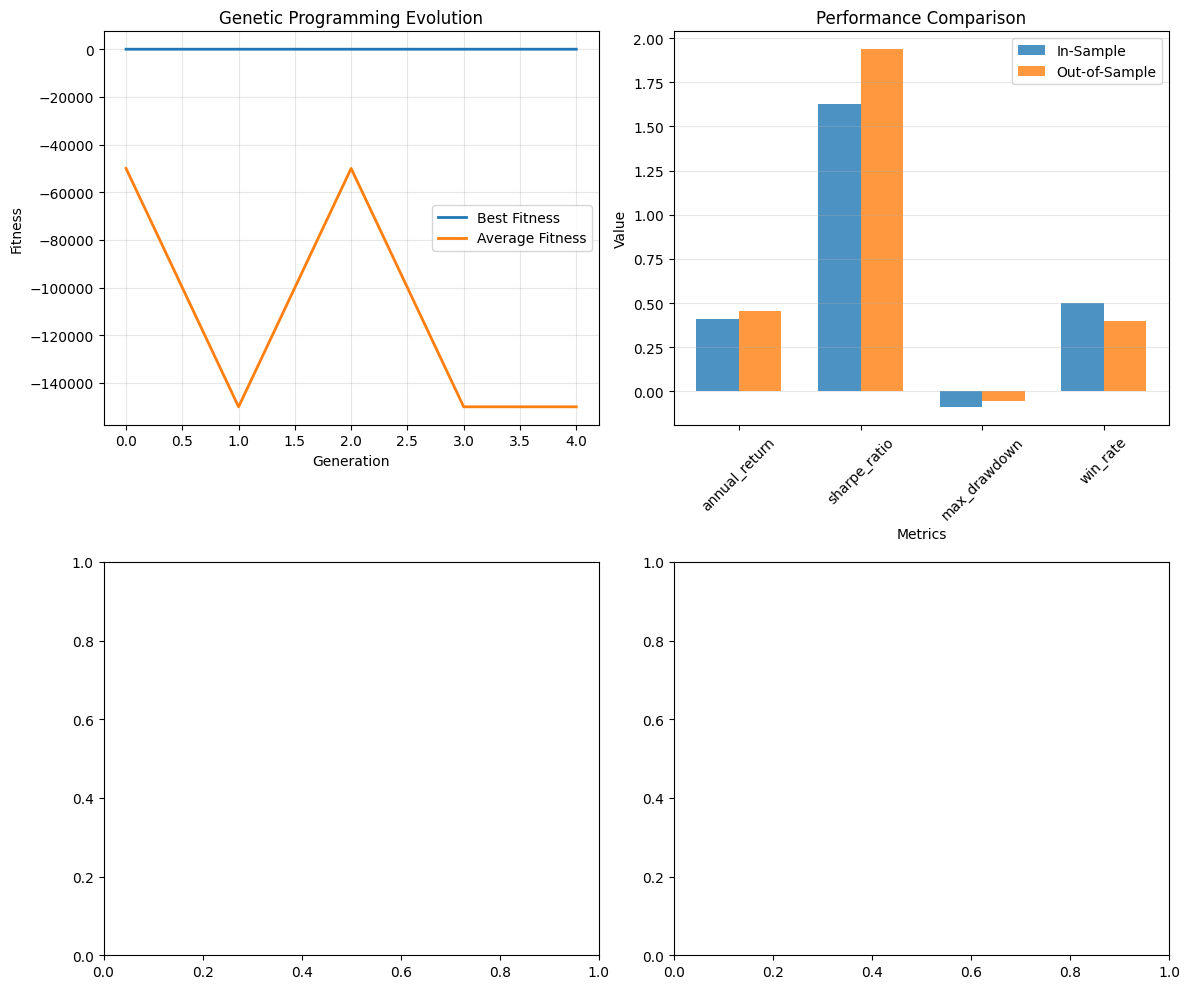


程序执行完成！


In [10]:
if __name__ == "__main__":
    # 运行主程序
    results = main()
    
    # 尝试可视化结果
    try:
        visualize_results(results)
    except:
        print("\n可视化模块需要matplotlib库，可通过 'pip install matplotlib' 安装")
    
    print("\n程序执行完成！")